In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import random

In [2]:
plays_df = pd.concat(map(pd.read_csv, glob.glob(f'data/nfl-big-data-bowl-*/plays.csv')))
plays_df.head()

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,specialTeamsPlayType,specialTeamsResult,kickerId,...,dropBackType,pff_playAction,pff_passCoverage,pff_passCoverageType,playType,numberOfPassRushers,typeDropback,offensePlayResult,epa,isDefensivePI
0,2018090600,37,J.Elliott kicks 65 yards from PHI 35 to end zo...,1,0,0,PHI,Kickoff,Touchback,44966.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018090600,366,"(9:20) C.Johnston punts 56 yards to ATL 36, Ce...",1,4,4,PHI,Punt,Return,45603.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018090600,658,"(5:03) M.Bryant 21 yard field goal is GOOD, Ce...",1,4,3,ATL,Field Goal,Kick Attempt Good,27091.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018090600,677,M.Bosher kicks 64 yards from ATL 35 to PHI 1. ...,1,0,0,ATL,Kickoff,Return,37267.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018090600,872,"(:33) C.Johnston punts 65 yards to end zone, C...",1,4,18,PHI,Punt,Touchback,45603.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [157]:
games_df = pd.concat(map(pd.read_csv, glob.glob(f'data/nfl-big-data-bowl-*/games.csv')))
games_df.head()

,gameId,season,week,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr,homeFinalScore,visitorFinalScore
0,2018090600,2018.0,1,09/06/2018,20:20:00,PHI,ATL,NaN,NaN
1,2018090900,2018.0,1,09/09/2018,13:00:00,BAL,BUF,NaN,NaN
2,2018090901,2018.0,1,09/09/2018,13:00:00,CLE,PIT,NaN,NaN
3,2018090902,2018.0,1,09/09/2018,13:00:00,IND,CIN,NaN,NaN
4,2018090903,2018.0,1,09/09/2018,13:00:00,MIA,TEN,NaN,NaN


In [3]:
plays_df.dtypes

gameId                                int64
playId                                int64
playDescription                      object
quarter                               int64
down                                  int64
yardsToGo                             int64
possessionTeam                       object
specialTeamsPlayType                 object
specialTeamsResult                   object
kickerId                            float64
returnerId                           object
kickBlockerId                       float64
yardlineSide                         object
yardlineNumber                        int64
gameClock                            object
penaltyCodes                         object
penaltyJerseyNumbers                 object
penaltyYards                        float64
preSnapHomeScore                    float64
preSnapVisitorScore                 float64
passResult                           object
kickLength                          float64
kickReturnYardage               

In [4]:
plays_df['play_uuid'] = plays_df['gameId'].astype(str) + '.' + plays_df['playId'].astype(str)
plays_df['play_uuid'].head()

0     2018090600.37
1    2018090600.366
2    2018090600.658
3    2018090600.677
4    2018090600.872
Name: play_uuid, dtype: object

In [6]:
# prompt: load all CSV files with a name like "tracking_week_" into a tracking_df dataframe
import glob
tracking_df = pd.concat(map(pd.read_csv, glob.glob(f'data/nfl-big-data-bowl-*/*week*.csv')))

In [7]:
tracking_df['play_uuid'] = tracking_df['gameId'].astype(str) + '.' + tracking_df['playId'].astype(str)
tracking_df['play_uuid'].head()

0    2022100600.90
1    2022100600.90
2    2022100600.90
3    2022100600.90
4    2022100600.90
Name: play_uuid, dtype: object

In [57]:
tracking_df['event'].unique()

array([nan, 'ball_snap', 'handoff', 'first_contact', 'tackle',
       'pass_arrived', 'pass_outcome_caught', 'out_of_bounds', 'run',
       'fumble', 'man_in_motion', 'autoevent_passforward', 'shift',
       'play_action', 'touchdown', 'pass_forward', 'snap_direct',
       'line_set', 'qb_slide', 'autoevent_ballsnap',
       'autoevent_passinterrupted', 'pass_shovel', 'lateral',
       'penalty_flag', 'qb_sack', 'fumble_offense_recovered', 'safety',
       'pass_outcome_touchdown', 'fumble_defense_recovered',
       'run_pass_option', 'penalty_accepted', 'pass_outcome_incomplete',
       'pass_tipped', 'qb_strip_sack', 'huddle_break_offense',
       'dropped_pass', 'pass_outcome_interception', 'touchback',
       'qb_spike', 'field_goal_blocked', 'punt_fake', 'pass_lateral',
       'field_goal_fake', 'huddle_start_offense', 'timeout_home',
       'field_goal_play'], dtype=object)

In [122]:
ball_snap_df = tracking_df.loc[(tracking_df['event'] == 'ball_snap')]
ball_snap_df['team'] = ball_snap_df['team'].combine_first(ball_snap_df['club'])
ball_snap_df.head()

/var/folders/m8/xlwp526d3sxf6fyr2v802l_80000gn/T/ipykernel_65573/2019373593.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ball_snap_df['team'] = ball_snap_df['team'].combine_first(ball_snap_df['club'])


,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,...,s,a,dis,o,dir,event,team,position,route,play_uuid
5,2022100600,90,33084.0,Matt Ryan,6,2022-10-06 20:17:05.299999,2.0,IND,left,90.26,...,0.20,0.14,0.04,274.45,250.64,ball_snap,IND,NaN,NaN,2022100600.90
65,2022100600,90,35459.0,Kareem Jackson,6,2022-10-06 20:17:05.299999,22.0,DEN,left,72.17,...,0.48,0.94,0.05,119.60,125.33,ball_snap,DEN,NaN,NaN,2022100600.90
125,2022100600,90,42030.0,K'Waun Williams,6,2022-10-06 20:17:05.299999,21.0,DEN,left,80.22,...,3.41,2.96,0.35,128.25,199.16,ball_snap,DEN,NaN,NaN,2022100600.90
185,2022100600,90,42393.0,Ronald Darby,6,2022-10-06 20:17:05.299999,23.0,DEN,left,76.83,...,0.04,0.14,0.01,73.29,206.98,ball_snap,DEN,NaN,NaN,2022100600.90
245,2022100600,90,43307.0,Ryan Kelly,6,2022-10-06 20:17:05.299999,78.0,IND,left,85.75,...,0.08,0.38,0.01,252.44,311.45,ball_snap,IND,NaN,NaN,2022100600.90


In [130]:
position_counts = ball_snap_df[['play_uuid', 'nflId']].groupby('play_uuid').count()
all_22_play_ids = position_counts.loc[(position_counts['nflId'] == 22)].index
all_22_play_ids

Index(['2018091607.329', '2018093011.544', '2018111106.554', '2018111808.1165',
       '2018120901.1570', '2021090900.1078', '2021090900.1203',
       '2021090900.1227', '2021090900.1267', '2021090900.1312',
       ...
       '2022110700.3787', '2022110700.403', '2022110700.443', '2022110700.493',
       '2022110700.546', '2022110700.612', '2022110700.670', '2022110700.80',
       '2022110700.929', '2022110700.950'],
      dtype='object', name='play_uuid', length=14860)

In [132]:
all_22_plays = plays_df.loc[(plays_df['play_uuid'].isin(all_22_play_ids))]
all_22_plays

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,specialTeamsPlayType,specialTeamsResult,kickerId,...,pff_playAction,pff_passCoverage,pff_passCoverageType,playType,numberOfPassRushers,typeDropback,offensePlayResult,epa,isDefensivePI,play_uuid
1594,2018093011,544,(6:59) (Punt formation) T.Hill pass short righ...,1,4,2,NO,Punt,Non-Special Teams Result,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018093011.544
3798,2018111106,554,(7:26) (Punt formation) L.Thomas pass short ri...,1,4,6,BUF,Punt,Non-Special Teams Result,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018111106.554
4228,2018111808,1165,(12:58) (Punt formation) C.Wadman pass short l...,2,4,5,DEN,Punt,Non-Special Teams Result,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018111808.1165
5231,2018120901,1570,(8:18) (Punt formation) J.Hekker pass short ri...,2,4,7,LA,Punt,Non-Special Teams Result,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018120901.1570
1,2022091103,3126,(7:38) (Shotgun) C.Claypool right end to PIT 3...,4,1,10,PIT,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022091103.3126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1647,2018091607,329,(10:00) (Punt formation) K.Byard pass deep rig...,1,4,6,TEN,NaN,NaN,NaN,...,NaN,NaN,NaN,play_type_pass,5.0,UNKNOWN,66.0,8.397043,False,2018091607.329
4341,2018093011,544,(6:59) (Punt formation) T.Hill pass short righ...,1,4,2,NO,NaN,NaN,NaN,...,NaN,NaN,NaN,play_type_pass,3.0,UNKNOWN,10.0,3.778991,False,2018093011.544
10443,2018111106,554,(7:26) (Punt formation) L.Thomas pass short ri...,1,4,6,BUF,NaN,NaN,NaN,...,NaN,NaN,NaN,play_type_pass,0.0,UNKNOWN,15.0,4.099472,False,2018111106.554
11587,2018111808,1165,(12:58) (Punt formation) C.Wadman pass short l...,2,4,5,DEN,NaN,NaN,NaN,...,NaN,NaN,NaN,play_type_pass,0.0,UNKNOWN,12.0,3.870902,False,2018111808.1165


In [138]:
third_down_df = all_22_plays.loc[(all_22_plays['down'] == 3)]
third_down_df.columns

Index(['gameId', 'playId', 'playDescription', 'quarter', 'down', 'yardsToGo',
       'possessionTeam', 'specialTeamsPlayType', 'specialTeamsResult',
       'kickerId', 'returnerId', 'kickBlockerId', 'yardlineSide',
       'yardlineNumber', 'gameClock', 'penaltyCodes', 'penaltyJerseyNumbers',
       'penaltyYards', 'preSnapHomeScore', 'preSnapVisitorScore', 'passResult',
       'kickLength', 'kickReturnYardage', 'playResult',
       'absoluteYardlineNumber', 'ballCarrierId', 'ballCarrierDisplayName',
       'defensiveTeam', 'passLength', 'prePenaltyPlayResult',
       'playNullifiedByPenalty', 'offenseFormation', 'defendersInTheBox',
       'passProbability', 'preSnapHomeTeamWinProbability',
       'preSnapVisitorTeamWinProbability', 'homeTeamWinProbabilityAdded',
       'visitorTeamWinProbilityAdded', 'expectedPoints', 'expectedPointsAdded',
       'foulName1', 'foulName2', 'foulNFLId1', 'foulNFLId2', 'foulName3',
       'foulNFLId3', 'personnelO', 'defendersInBox', 'personnelD',
     

In [139]:
all_22_frames_df = ball_snap_df.loc[(ball_snap_df['play_uuid'].isin(all_22_play_ids))]
all_22_frames_df.head()

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,...,s,a,dis,o,dir,event,team,position,route,play_uuid
5,2022100600,90,33084.0,Matt Ryan,6,2022-10-06 20:17:05.299999,2.0,IND,left,90.26,...,0.20,0.14,0.04,274.45,250.64,ball_snap,IND,NaN,NaN,2022100600.90
65,2022100600,90,35459.0,Kareem Jackson,6,2022-10-06 20:17:05.299999,22.0,DEN,left,72.17,...,0.48,0.94,0.05,119.60,125.33,ball_snap,DEN,NaN,NaN,2022100600.90
125,2022100600,90,42030.0,K'Waun Williams,6,2022-10-06 20:17:05.299999,21.0,DEN,left,80.22,...,3.41,2.96,0.35,128.25,199.16,ball_snap,DEN,NaN,NaN,2022100600.90
185,2022100600,90,42393.0,Ronald Darby,6,2022-10-06 20:17:05.299999,23.0,DEN,left,76.83,...,0.04,0.14,0.01,73.29,206.98,ball_snap,DEN,NaN,NaN,2022100600.90
245,2022100600,90,43307.0,Ryan Kelly,6,2022-10-06 20:17:05.299999,78.0,IND,left,85.75,...,0.08,0.38,0.01,252.44,311.45,ball_snap,IND,NaN,NaN,2022100600.90


In [140]:
third_down_frames_df = ball_snap_df.loc[(ball_snap_df['play_uuid'].isin(third_down_df['play_uuid']))]
third_down_frames_df.head()

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,...,s,a,dis,o,dir,event,team,position,route,play_uuid
22683,2022100600,1069,38540.0,Stephon Gilmore,6,2022-10-06 20:58:22.400000,5.0,IND,left,38.44,...,0.05,0.05,0.00,37.15,272.30,ball_snap,IND,NaN,NaN,2022100600.1069
22734,2022100600,1069,38605.0,Russell Wilson,6,2022-10-06 20:58:22.400000,3.0,DEN,left,45.20,...,0.00,0.00,0.01,272.11,354.59,ball_snap,DEN,NaN,NaN,2022100600.1069
22785,2022100600,1069,38843.0,Rodney McLeod,6,2022-10-06 20:58:22.400000,26.0,IND,left,40.60,...,0.01,0.01,0.00,76.12,96.10,ball_snap,IND,NaN,NaN,2022100600.1069
22836,2022100600,1069,41369.0,Cameron Fleming,6,2022-10-06 20:58:22.400000,73.0,DEN,left,45.05,...,0.56,1.91,0.06,273.86,214.51,ball_snap,DEN,NaN,NaN,2022100600.1069
22887,2022100600,1069,42358.0,Melvin Gordon,6,2022-10-06 20:58:22.400000,25.0,DEN,left,49.91,...,0.11,0.63,0.01,261.38,256.08,ball_snap,DEN,NaN,NaN,2022100600.1069


In [141]:
third_down_frames_df.columns

Index(['gameId', 'playId', 'nflId', 'displayName', 'frameId', 'time',
       'jerseyNumber', 'club', 'playDirection', 'x', 'y', 's', 'a', 'dis', 'o',
       'dir', 'event', 'team', 'position', 'route', 'play_uuid'],
      dtype='object')

In [182]:
random_play =  random.randint(0, len(third_down_frames_df))
random_id = third_down_frames_df.iloc[random_play]['play_uuid']
play_frame = third_down_frames_df.loc[(third_down_frames_df['play_uuid'] == random_id)]
play_frame

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,...,s,a,dis,o,dir,event,team,position,route,play_uuid
928722,2021092611,4225,25511.0,NaN,6,2021-09-26T23:25:34.800,12.0,NaN,right,89.08,...,0.19,0.11,0.03,82.11,336.26,ball_snap,TB,NaN,NaN,2021092611.4225
928751,2021092611,4225,39985.0,NaN,6,2021-09-26T23:25:34.800,25.0,NaN,right,88.72,...,0.01,0.01,0.01,95.56,245.56,ball_snap,TB,NaN,NaN,2021092611.4225
928780,2021092611,4225,40151.0,NaN,6,2021-09-26T23:25:34.800,66.0,NaN,right,93.29,...,0.08,0.09,0.08,86.79,274.00,ball_snap,TB,NaN,NaN,2021092611.4225
928809,2021092611,4225,41233.0,NaN,6,2021-09-26T23:25:34.800,13.0,NaN,right,92.81,...,0.01,0.02,0.01,91.37,48.65,ball_snap,TB,NaN,NaN,2021092611.4225
928838,2021092611,4225,41239.0,NaN,6,2021-09-26T23:25:34.800,99.0,NaN,right,94.72,...,0.11,1.24,0.04,287.15,251.91,ball_snap,LA,NaN,NaN,2021092611.4225
928867,2021092611,4225,42033.0,NaN,6,2021-09-26T23:25:34.800,84.0,NaN,right,93.01,...,0.00,0.01,0.01,66.61,194.44,ball_snap,TB,NaN,NaN,2021092611.4225
928896,2021092611,4225,42377.0,NaN,6,2021-09-26T23:25:34.800,76.0,NaN,right,92.49,...,0.07,0.07,0.04,77.38,177.74,ball_snap,TB,NaN,NaN,2021092611.4225
928925,2021092611,4225,42404.0,NaN,6,2021-09-26T23:25:34.800,74.0,NaN,right,92.59,...,0.15,0.72,0.01,54.07,340.82,ball_snap,TB,NaN,NaN,2021092611.4225
928954,2021092611,4225,43294.0,NaN,6,2021-09-26T23:25:34.800,5.0,NaN,right,101.25,...,0.24,0.42,0.02,81.49,14.53,ball_snap,LA,NaN,NaN,2021092611.4225
928983,2021092611,4225,43298.0,NaN,6,2021-09-26T23:25:34.800,54.0,NaN,right,94.89,...,0.42,0.06,0.07,278.88,307.09,ball_snap,LA,NaN,NaN,2021092611.4225


In [183]:
play = all_22_plays.loc[(all_22_plays['play_uuid'] == random_id)].iloc[0]
play

gameId                                                                     2021092611
playId                                                                           4225
playDescription                     (1:18) (No Huddle, Shotgun) T.Brady pass short...
quarter                                                                             4
down                                                                                3
yardsToGo                                                                           7
possessionTeam                                                                     TB
specialTeamsPlayType                                                              NaN
specialTeamsResult                                                                NaN
kickerId                                                                          NaN
returnerId                                                                        NaN
kickBlockerId                                         

In [185]:
game = games_df.loc[(games_df['gameId'] == play['gameId'])].iloc[0]
game

gameId               2021092611
season                   2021.0
week                          3
gameDate             09/26/2021
gameTimeEastern        16:25:00
homeTeamAbbr                 LA
visitorTeamAbbr              TB
homeFinalScore              NaN
visitorFinalScore           NaN
Name: 44, dtype: object

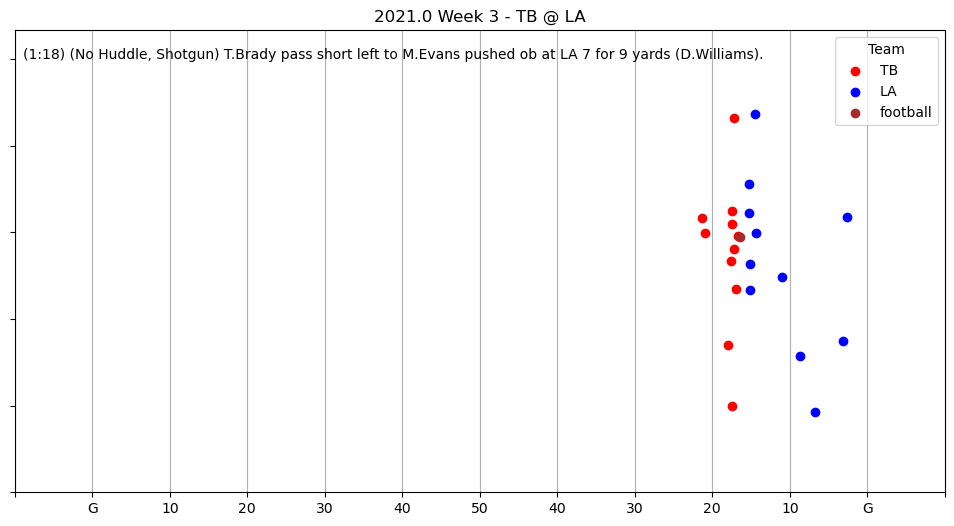

In [186]:
teams = play_frame['team'].unique()
colors = {teams[0]: 'red', teams[1]: 'blue', teams[2]: 'brown'}

plt.figure(figsize=(12, 6))

for team, color in colors.items():
    plt.scatter(play_frame[play_frame['team'] == team]['x'], play_frame[play_frame['team'] == team]['y'], c=color, label=team)

plt.title(f"{game['season']} Week {game['week']} - {game['visitorTeamAbbr']} @ {game['homeTeamAbbr']}")
plt.legend(title='Team')
plt.annotate(play['playDescription'], xy=[1,50])

# Set x and y scales
plt.xlim(0, 120)  # Adjust the limits according to your data
plt.ylim(0, 53.3)  # Adjust the limits according to your data

# Hide y-axis labels
plt.gca().set_yticklabels([])
plt.xticks([0,10,20,30,40,50,60,70,80,90,100,110,120])
plt.gca().set_xticklabels(['','G','10','20','30','40','50','40','30','20','10','G',''])

# Show plot
plt.grid(True, axis='x')
plt.show()
